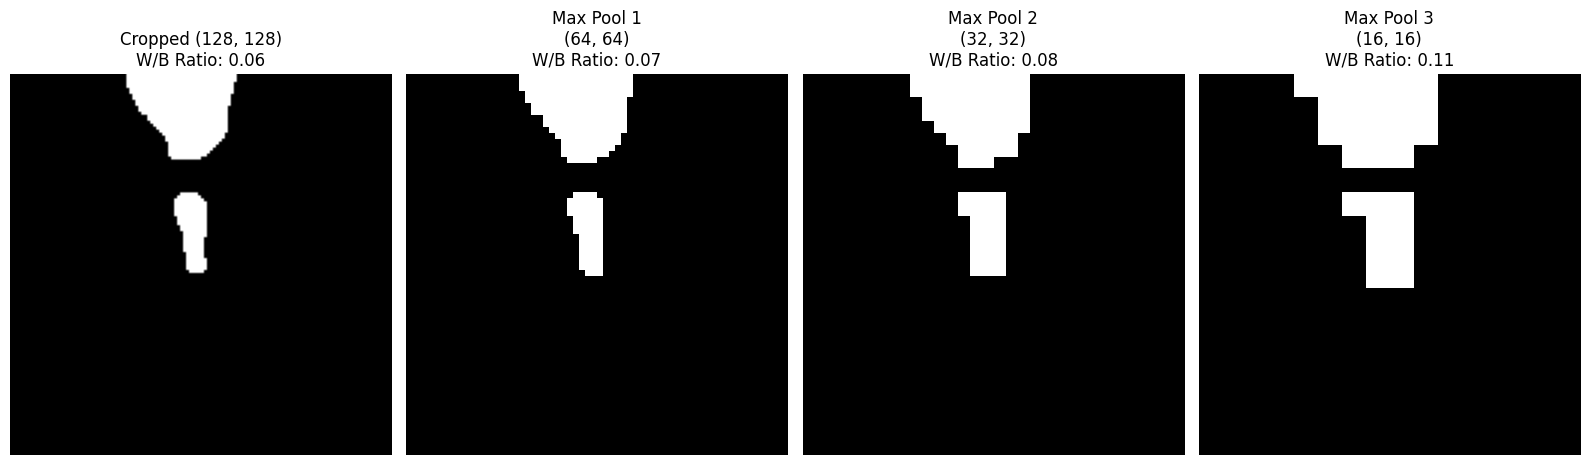

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def load_image(file_path):
    return np.load(file_path)

def center_crop(image, size):
    h, w = image.shape
    top = (h - size) // 2
    left = (w - size) // 2
    return image[top:top+size, left:left+size]

def max_pool(image, pool_size):
    tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).float()
    pooled = F.max_pool2d(tensor, kernel_size=pool_size, stride=pool_size)
    return pooled.squeeze().numpy()

def white_to_black_ratio(image):
    white_pixels = np.sum(image > 0.5)
    black_pixels = np.sum(image <= 0.5)
    return white_pixels / (black_pixels+white_pixels) if black_pixels > 0 else float('inf')

def plot_max_pooling(image, num_iterations=3, pool_size=(2, 2), crop_size=128):
    cropped_image = center_crop(image, crop_size)
    
    fig, axes = plt.subplots(1, num_iterations + 1, figsize=(4 * (num_iterations + 1), 10))
    
    ratio = white_to_black_ratio(cropped_image)
    axes[0].imshow(cropped_image, cmap='gray')
    axes[0].set_title(f'Cropped {cropped_image.shape}\nW/B Ratio: {ratio:.2f}')
    axes[0].axis('off')
    
    current_image = cropped_image
    for i in range(num_iterations):
        current_image = max_pool(current_image, pool_size)
        ratio = white_to_black_ratio(current_image)
        axes[i + 1].imshow(current_image, cmap='gray')
        axes[i + 1].set_title(f'Max Pool {i + 1}\n{current_image.shape}\nW/B Ratio: {ratio:.2f}')
        axes[i + 1].axis('off')
        
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    image_path = "/kaggle/input/ch4net-dataset/data/test/label/pos/1020.npy"  # Replace with your .npy file path
    image = load_image(image_path)
    plot_max_pooling(image)

In [2]:
import sys
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from glob import glob
import numpy as np
import torch
from random import shuffle
import random
from numpy import random as npr
import pandas as pd
import imageio
from PIL import Image


class MethaneLoader(DataLoader):

    def __init__(self, device, mode, plume_id, red=False, alli=False, channels=12):
        self.device = device
        self.mode = mode
        self.reduce = red
        self.channels = channels

        if mode == "train":
            persist = False
        else:
            persist = True
        
        if plume_id is not None:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/*/{}.npy".format(mode, plume_id)))
#             self.neg_labels = sorted(
#                 glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/{}.npy".format(mode, plume_id)))
            self.neg_labels = []
        else:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/*.npy".format(mode)))
            self.neg_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/neg/*.npy".format(mode)))

        self.labels = self.pos_labels+self.neg_labels  # None
        
        if not alli:
            self.sample_labels_and_combine(persist=persist)

    def sample_labels_and_combine(self, persist=False):
        """
        Sample a subset of negative labels for each epoch
        """
        # if self.mode == "test":
        if self.mode in ["val"]:
            self.labels = self.pos_labels+self.neg_labels
        else:
            if persist:
                random.seed(555)

            shuffle(self.neg_labels)
            self.labels = self.pos_labels + \
                self.neg_labels[:len(self.pos_labels)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        f = self.labels[index]
        # print(f)

        plume_id = int(f.split("/")[-1].split(".")[0])
        # print(plume_id)

        target = np.load(f)
        context = np.load(
            "/kaggle/input/ch4net-dataset/data/{}/s2/{}.npy".format(self.mode, plume_id))

        if self.channels == 2:
            context = context[..., 10:]
        if self.channels == 5:
            context = np.concatenate(
                [context[..., 1:4], context[..., 10:]], axis=-1)
        
        if self.mode == "train":
            # rotate by 90, 180, 270 degrees
            degrees = npr.choice([0, 90, 180, 270])
            context = np.rot90(context, k=degrees//90)
            target = np.rot90(target, k=degrees//90)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=0)
                target = np.flip(target, axis=0)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=1)
                target = np.flip(target, axis=1)

        # Crop to centre
        # x_c = target.shape[0]//2
        # y_c = target.shape[1]//2
        s = 64

        if self.mode == "train":
            rng = npr.RandomState()
            mid_loc_x = rng.randint(s, target.shape[0]-s)
            mid_loc_y = rng.randint(s, target.shape[1]-s)

        else:
            mid_loc_x = target.shape[0]//2
            mid_loc_y = target.shape[1]//2

        target = target[mid_loc_x-s:mid_loc_x+s,
                        mid_loc_y-s: mid_loc_y+s]

        context = context[mid_loc_x-s:mid_loc_x+s,
                          mid_loc_y-s: mid_loc_y+s, :]

        ### These are not defined before and not necessary for training. 
        ### But these are used in evaluation outputs
#         diff_img = np.array(diff_img[mid_loc_x-s:mid_loc_x+s,
#                                      mid_loc_y-s:mid_loc_y+s, :])
#         diff_img_g = np.array(diff_img_g[mid_loc_x-s:mid_loc_x+s,
#                                          mid_loc_y-s:mid_loc_y+s])
#         rgb_img = np.array(rgb_img[mid_loc_x-s:mid_loc_x+s,
#                                    mid_loc_y-s:mid_loc_y+s, :])

        if self.reduce:
            target = np.array([np.int(target.any())])

        # if self.mode == "test":
            # print("Plume ID: {}, date: {}".format(plume_id, date))

        d = {"pred": torch.from_numpy(context.copy()).float().to(self.device).permute(2, 0, 1)/255,
             "target": torch.from_numpy(target.copy()).float().to(self.device)}
        
        # Print the size of the image tensor
#         print("Image tensor size (context):", d["pred"].size())
#         print("Image tensor size (target):", d["target"].size())

        return d

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    """
    Base MLP module with ReLU activation
    Parameters:
    -----------
    in_channels: Int
        Number of input channels
    out_channels: Int
        Number of output channels
    h_channels: Int
        Number of hidden channels
    h_layers: Int
        Number of hidden layers
    """

    def __init__(self, 
                in_channels, 
                out_channels, 
                h_channels=64,
                h_layers=4):

        super().__init__()

        def hidden_block(h_channels):
            h = nn.Sequential(
            nn.Linear(h_channels, h_channels),
            nn.ReLU())
            return h

        # Model
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.ReLU(),
            *[hidden_block(h_channels) for _ in range(h_layers)],
            nn.Linear(h_channels, out_channels) 
        )

    def forward(self, x):
        return self.mlp(x)

class Unet(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 div_factor=8,
                 prob_output=True,
                 class_output=False

    ):
        super(Unet, self).__init__()

        self.n_channels = in_channels
        self.bilinear = True
        self.sigmoid = nn.Sigmoid()
        self.prob_output = prob_output
        self.class_output = class_output

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                # [?, C, H, W]
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1) ## why 1?
                return self.conv(x)

        self.inc = double_conv(self.n_channels, 64//div_factor)
        self.down1 = down(64//div_factor, 128//div_factor)
        self.down2 = down(128//div_factor, 256//div_factor)
        self.down3 = down(256//div_factor, 512//div_factor)
        self.down4 = down(512//div_factor, 512//div_factor)
        self.up1 = up(1024//div_factor, 256//div_factor)
        self.up2 = up(512//div_factor, 128//div_factor)
        self.up3 = up(256//div_factor, 64//div_factor)
        self.up4 = up(128//div_factor, 128//div_factor)
        self.out = nn.Conv2d(128//div_factor, 1, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        #return self.out(x).permute(0,2,3,1)

        if self.prob_output:
            x = self.out(x)
            return self.sigmoid(x).permute(0,2,3,1)
        else:
            return self.out(x).permute(0,2,3,1)

In [4]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class UNet_Attention(nn.Module):
    def __init__(self, img_ch=12, output_ch=1):
        super(UNet_Attention, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv_out_2 = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)
        self.Conv_out_3 = nn.Conv2d(filters[1], output_ch, kernel_size=1, stride=1, padding=0)
        self.Conv_out_4 = nn.Conv2d(filters[2], output_ch, kernel_size=1, stride=1, padding=0)
        self.Conv_out_5 = nn.Conv2d(filters[3], output_ch, kernel_size=1, stride=1, padding=0)
        
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)
        
        d5 = self.dropout(d5)

        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out2 = self.Conv_out_2(d2)
        out3 = self.Conv_out_3(d3)
        out4 = self.Conv_out_4(d4)
        out5 = self.Conv_out_5(d5)

#         return out
        return out2, out3, out4, out5


# Example usage:


model = UNet_Attention(img_ch=12, output_ch=1)
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16
target_tensor = torch.randn(16, 128, 128)
target_tensor = target_tensor.unsqueeze(1)
output = model(input_tensor)

# Check output shape
print(f"Output shape: {output[1].shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]

Output shape: torch.Size([16, 1, 64, 64])
Target shape: torch.Size([16, 1, 128, 128])


In [5]:
!mkdir -p /kaggle/working/train_out
!mkdir -p /kaggle/working/eval_out

In [6]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.1 MB/s eta 0:00:00a 0:00:01


In [11]:
import torch
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss
from monai.losses.hausdorff_loss import HausdorffDTLoss

def loss(pred, target):
#     print(pred.shape, target.shape)
    bce_loss = nn.BCEWithLogitsLoss(reduction="none") 
    ll = bce_loss(pred, target)

    ll = ll.sum(dim=(-2,-1)) #*mask
    return ll.mean()


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce_loss = nn.BCEWithLogitsLoss(reduction="none")
    
    def forward(self, pred, target):
        loss = self.bce_loss(pred, target)
        prob = torch.sigmoid(pred)  # Predicted probability
        alpha = torch.where(target == 1, self.alpha, 1 - self.alpha)  # Class balancing factor
        focal_weight = torch.where(target == 1, 1 - prob, prob)  # Focusing weight
        focal_weight = alpha * focal_weight**self.gamma  # Apply alpha and gamma
        focal_loss = focal_weight * loss
        
        focal_loss = focal_loss.sum(dim=(-2,-1)) #*mask
        
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss

    
class MultiScalePoolingLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2, itr=3, ratio=None):
        super(MultiScalePoolingLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.itr = itr
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma)
        self.ratio = torch.tensor(ratio)
    
    def forward(self, pred, target):
        losses = torch.zeros(self.itr)
        if(pred.dim() == 2):
            pred = pred.unsqueeze(0)
            target = target.unsqueeze(0)
        elif(pred.dim() == 3):
            pred = pred.unsqueeze(1)
            target = target.unsqueeze(1)
        for i in range(self.itr):
            losses[i] = self.focal_loss(pred, target)
            pred = F.max_pool2d(pred, kernel_size=2, stride=2)
            target = F.max_pool2d(target, kernel_size=2, stride=2)
        
        if self.ratio is not None:
            losses = losses * self.ratio
        else:
            losses = losses * 1/self.itr
        
        return torch.sum(losses)

    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        # Flatten label and prediction tensors
        inputs = inputs.view(inputs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        
        # Compute Dice loss
        intersection = (inputs * targets).sum(dim=1)
        dice_loss = 1 - (2.0 * intersection + smooth) / (inputs.sum(dim=1) + targets.sum(dim=1) + smooth)

        # Compute BCE loss
        BCE = F.binary_cross_entropy(inputs, targets, reduction='none')
        BCE = BCE.mean(dim=1)

        # Combine Dice and BCE losses
        Dice_BCE = BCE + dice_loss

        return Dice_BCE.mean()

    
class HausdorffDT_Loss(nn.Module):
    def __init__(self):
        super(HausdorffDT_Loss, self).__init__()
        self.hd_loss = HausdorffDTLoss(reduction='mean', sigmoid=True)
        self.focal_loss = FocalLoss

    def forward(self, inputs, targets):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        return self.hd_loss(inputs.unsqueeze(1), targets.unsqueeze(1))

    
class HausdorffDT_Focal_Loss(nn.Module):
    def __init__(self, focal_weight = 0.65):
        super(HausdorffDT_Focal_Loss, self).__init__()
        self.hd_loss = HausdorffDTLoss(reduction='none', sigmoid=True)
        self.focal_loss = FocalLoss(alpha=0.75, gamma=2.0, reduction='none')
        self.focal_weight = focal_weight

    def forward(self, inputs, targets):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        hl = self.hd_loss(inputs.unsqueeze(1), targets.unsqueeze(1))
        fl = self.focal_loss(inputs, targets)
        final_loss = self.focal_weight * torch.squeeze(fl) + (1-self.focal_weight) * torch.squeeze(hl)
        return torch.mean(final_loss)
    
    
class GuidedLoss(nn.Module):
    def __init__(self):
        super(GuidedLoss, self).__init__()
        self.focal_loss_4 = FocalLoss(alpha=.75, gamma=4, reduction='none')
        self.focal_loss_3 = FocalLoss(alpha=.7, gamma=3.3, reduction='none')
        self.focal_loss_2 = FocalLoss(alpha=.65, gamma=2.5, reduction='none')
        self.focal_loss_1 = FocalLoss(alpha=.6, gamma=1.7, reduction='none')
        self.hd_loss = HausdorffDTLoss(reduction='none', sigmoid=True)
        self.layer_weights = torch.tensor([0.5, 0.2, 0.2, 0.1])
        self.log_vars = nn.Parameter(torch.zeros(2))

    def forward(self, pred, target):
        in_layer_4, in_layer_3, in_layer_2, in_layer_1 = pred
        device = in_layer_4.device
    
        f_4 = self.focal_loss_4(in_layer_4, target)
        h_4 = self.hd_loss(in_layer_4.unsqueeze(1), target.unsqueeze(1))

        target_3 = F.max_pool2d(target, kernel_size=2, stride=2)
        f_3 = self.focal_loss_3(in_layer_3, target_3)
        h_3 = self.hd_loss(in_layer_3.unsqueeze(1), target_3.unsqueeze(1))

        target_2 = F.max_pool2d(target_3, kernel_size=2, stride=2)
        f_2 = self.focal_loss_2(in_layer_2, target_2)
        h_2 = self.hd_loss(in_layer_2.unsqueeze(1), target_2.unsqueeze(1))

        target_1 = F.max_pool2d(target_2, kernel_size=2, stride=2)
        f_1 = self.focal_loss_1(in_layer_1, target_1)
        h_1 = self.hd_loss(in_layer_1.unsqueeze(1), target_1.unsqueeze(1))

        focal_loss_tensor = torch.stack([f_4, f_3, f_2, f_1], dim=0).to(device)
        hd_loss_tensor = torch.stack([h_4, h_3, h_2, h_1], dim=0).to(device)
        weighted_loss_tensor_fl = focal_loss_tensor * self.layer_weights.view(4, 1).to(device)
        weighted_loss_tensor_hd = hd_loss_tensor * self.layer_weights.view(4, 1).to(device)
#         print(weighted_loss_tensor.shape)
        summed_tensor_fl = weighted_loss_tensor_fl.sum(dim=1)
        summed_tensor_hd = weighted_loss_tensor_hd.sum(dim=1)

        precision1 = torch.exp(-self.log_vars[0])
        summed_tensor_fl = precision1 * summed_tensor_fl + self.log_vars[0]

        precision2 = torch.exp(-self.log_vars[1])
        summed_tensor_hd = precision2 * summed_tensor_hd + self.log_vars[1]
        

        final_loss = summed_tensor_fl + summed_tensor_hd
#         print(summed_tensor.shape)
        final_loss = final_loss.sum(axis=0)
        
        return torch.mean(final_loss)
    
    
model = UNet_Attention(img_ch=12, output_ch=1)
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16
target_tensor = torch.randn(16, 128, 128)
output = model(input_tensor)
print(output[0].shape)
output = tuple(np.squeeze(o) for o in output)
print(output[0][0].shape)

# Check output shape
print(f"Output shape: {output[1].shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]

guided_loss = GuidedLoss()
print(guided_loss(tuple(np.squeeze(o) for o in output), target_tensor))

torch.Size([16, 1, 128, 128])
torch.Size([128, 128])
Output shape: torch.Size([16, 64, 64])
Target shape: torch.Size([16, 128, 128])


/opt/conda/lib/python3.10/site-packages/monai/losses/hausdorff_loss.py:171: UserWarning: single channel prediction, `include_background=False` ignored.
  warnings.warn("single channel prediction, `include_background=False` ignored.")


tensor(8103.0698, grad_fn=<MeanBackward0>)


In [12]:
from matplotlib import pyplot as plt
import torch
import scipy
import numpy as np
from tqdm import tqdm
from torch import autograd
from torch.utils.data import DataLoader
# from loader import *


class Trainer():
    """
    Training class for the neural process models
    """

    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 train_dataset,
                 loss_function,
                 save_path,
                 learning_rate):

        # Model and data
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.train_dataset = train_dataset
        self.save_path = save_path

        # Training parameters
        self.loss_function = loss_function
        self.opt = torch.optim.Adam(list(model.parameters()) + list(self.loss_function.parameters()), lr=learning_rate)
        self.sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt, mode='min', factor=0.5, patience=7, verbose=True)

        # Losses
        self.losses = []
        self.mIoUs = []

    def plot_losses(self):
        """
        Plot losses and IoUs in same figure
        """
        
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color=color)
        ax1.plot(self.losses, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('mIoU', color=color)
        ax2.plot(self.mIoUs, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()
        plt.show()

    def _unravel_to_numpy(self, x):
        return x.view(-1).detach().cpu().numpy()

    def eval_epoch(self, verbose=False):

        self.model.eval()
        lf = []
        ious = []

        def calculate_iou(pred, target):
            eps = 1e-6
            # convert to sigmoid then to binary
            pred = F.sigmoid(pred)
            pred = (pred > 0.5).float()
            target = target.float()
            
            return (torch.sum(pred * target) + eps) / (torch.sum(pred + target) + eps)
        
        with torch.no_grad():
            for task in self.val_loader:

                out = self.model(task["pred"])
                lf.append(self.loss_function(tuple(np.squeeze(o) for o in out), task["target"]))
                ious.append(calculate_iou(out[0], task["target"]))

        # Get loss function
        log_loss = torch.mean(torch.tensor(lf))
        print("- Log loss: {}".format(log_loss))
        mIoU = torch.mean(torch.tensor(ious))
        print("- mIoU: {}".format(mIoU))

        return log_loss, mIoU

    def train(self, n_epochs=100):

        # Init progress bar
        best_loss = 100000
        best_model_state_dict = None
        best_opt_state_dict = None
        i = 1

        for epoch in range(n_epochs):

            autograd.set_detect_anomaly(True)

            print("Training epoch {}".format(epoch))

            if epoch < 500:
                self.model.train()
                self.train_dataset.sample_labels_and_combine()
                self.train_loader = DataLoader(self.train_dataset,
                                               batch_size=16,
                                               shuffle=True)

            with tqdm(self.train_loader, unit="batch") as tepoch:
                for task in tepoch:

                    out = self.model(task["pred"])

                    # print("loss")
                    loss = self.loss_function(tuple(np.squeeze(o) for o in out), task["target"])

                    loss.backward()
                    self.opt.step()
                    self.opt.zero_grad()
                    # print("out")
                    tepoch.set_postfix(loss=loss.item())
                epoch_loss, mIoU = self.eval_epoch(verbose=False)
                self.sched.step(epoch_loss)
#                 print(self.sched.get_last_lr())

            if np.logical_or(epoch_loss <= best_loss, epoch >= 1000):
                best_model_state_dict = self.model.state_dict()
                best_opt_state_dict = self.opt.state_dict()
                best_loss = epoch_loss

            self.losses.append(epoch_loss)
            self.mIoUs.append(mIoU)

            # checkpoint
            if i % 10 == 0 or i == n_epochs:
                np.save(self.save_path+"losses.npy", np.array(self.losses))
                self.plot_losses()

                torch.save({
                    # 'epoch': epoch,
                    'model_state_dict': best_model_state_dict,
                    'optimizer_state_dict': best_opt_state_dict,
                    'loss': best_loss
                }, self.save_path+"final_model".format(epoch))
                
                best_loss = 100000   # pick the best loss in every checkpoint interval (not globally)
            i += 1

        print("Training complete!")

Training epoch 0


100%|██████████| 75/75 [01:02<00:00,  1.20batch/s, loss=2.5e+3] 


- Log loss: 1690.67626953125
- mIoU: 0.0019261304987594485
Training epoch 1


100%|██████████| 75/75 [00:38<00:00,  1.92batch/s, loss=1.68e+3]


- Log loss: 1474.6058349609375
- mIoU: 0.00021581145119853318
Training epoch 2


100%|██████████| 75/75 [00:38<00:00,  1.96batch/s, loss=1.65e+3]


- Log loss: 1286.0953369140625
- mIoU: 1.1802907238234184e-06
Training epoch 3


100%|██████████| 75/75 [00:37<00:00,  1.99batch/s, loss=1.41e+3]


- Log loss: 1179.60888671875
- mIoU: 0.00017398415366187692
Training epoch 4


100%|██████████| 75/75 [00:36<00:00,  2.03batch/s, loss=978]    


- Log loss: 1099.16943359375
- mIoU: 9.836022400122602e-06
Training epoch 5


100%|██████████| 75/75 [00:36<00:00,  2.04batch/s, loss=1.54e+3]


- Log loss: 1062.28125
- mIoU: 1.6374889291737027e-11
Training epoch 6


100%|██████████| 75/75 [00:36<00:00,  2.08batch/s, loss=1.15e+3]


- Log loss: 1015.5087890625
- mIoU: 1.8522119601960263e-11
Training epoch 7


100%|██████████| 75/75 [00:35<00:00,  2.13batch/s, loss=1.06e+3]


- Log loss: 1013.6688842773438
- mIoU: 2.79213026033176e-07
Training epoch 8


100%|██████████| 75/75 [00:34<00:00,  2.17batch/s, loss=997]    


- Log loss: 983.7332763671875
- mIoU: 1.7113624753428702e-11
Training epoch 9


100%|██████████| 75/75 [00:33<00:00,  2.21batch/s, loss=709]    


- Log loss: 967.7432861328125
- mIoU: 2.4194201614591293e-05


Training epoch 10


100%|██████████| 75/75 [00:33<00:00,  2.22batch/s, loss=784]    


- Log loss: 929.0576171875
- mIoU: 3.1020106234791456e-06
Training epoch 11


100%|██████████| 75/75 [00:33<00:00,  2.22batch/s, loss=888]    


- Log loss: 1049.84765625
- mIoU: 0.0033130780793726444
Training epoch 12


100%|██████████| 75/75 [00:33<00:00,  2.24batch/s, loss=1.31e+3]


- Log loss: 944.4877319335938
- mIoU: 0.001202836399897933
Training epoch 13


100%|██████████| 75/75 [00:34<00:00,  2.18batch/s, loss=751]    


- Log loss: 963.4361572265625
- mIoU: 0.0006935028359293938
Training epoch 14


100%|██████████| 75/75 [00:34<00:00,  2.15batch/s, loss=601]    


- Log loss: 1119.0615234375
- mIoU: 0.01961997151374817
Training epoch 15


100%|██████████| 75/75 [00:33<00:00,  2.22batch/s, loss=903]    


- Log loss: 991.7432861328125
- mIoU: 0.0035577306989580393
Training epoch 16


100%|██████████| 75/75 [00:33<00:00,  2.24batch/s, loss=952]    


- Log loss: 958.9238891601562
- mIoU: 0.007601121440529823
Training epoch 17


100%|██████████| 75/75 [00:34<00:00,  2.21batch/s, loss=1.06e+3]


- Log loss: 1016.851806640625
- mIoU: 0.014454567804932594
Training epoch 18


100%|██████████| 75/75 [00:33<00:00,  2.24batch/s, loss=1.14e+3]


- Log loss: 1184.293701171875
- mIoU: 0.00650909123942256
Training epoch 19


100%|██████████| 75/75 [00:33<00:00,  2.21batch/s, loss=1.14e+3]


- Log loss: 864.1807250976562
- mIoU: 0.0169061291962862


Training epoch 20


100%|██████████| 75/75 [00:34<00:00,  2.19batch/s, loss=641]    


- Log loss: 850.455810546875
- mIoU: 0.012674280442297459
Training epoch 21


100%|██████████| 75/75 [00:33<00:00,  2.25batch/s, loss=808]    


- Log loss: 862.5055541992188
- mIoU: 0.017413245514035225
Training epoch 22


100%|██████████| 75/75 [00:34<00:00,  2.17batch/s, loss=881]    


- Log loss: 805.8024291992188
- mIoU: 0.019866609945893288
Training epoch 23


100%|██████████| 75/75 [00:33<00:00,  2.25batch/s, loss=1.26e+3]


- Log loss: 957.1896362304688
- mIoU: 0.01710592769086361
Training epoch 24


100%|██████████| 75/75 [00:33<00:00,  2.24batch/s, loss=637]    


- Log loss: 861.1018676757812
- mIoU: 0.020634055137634277
Training epoch 25


100%|██████████| 75/75 [00:33<00:00,  2.22batch/s, loss=551]    


- Log loss: 885.4740600585938
- mIoU: 0.01801113598048687
Training epoch 26


100%|██████████| 75/75 [00:33<00:00,  2.27batch/s, loss=564]    


- Log loss: 1006.0764770507812
- mIoU: 0.03219703957438469
Training epoch 27


100%|██████████| 75/75 [00:33<00:00,  2.26batch/s, loss=894]    


- Log loss: 865.7432861328125
- mIoU: 0.030097177252173424
Training epoch 28


100%|██████████| 75/75 [00:32<00:00,  2.27batch/s, loss=537]    


- Log loss: 867.2617797851562
- mIoU: 0.02719276398420334
Training epoch 29


100%|██████████| 75/75 [00:33<00:00,  2.25batch/s, loss=1.18e+3]


- Log loss: 738.51513671875
- mIoU: 0.021924085915088654


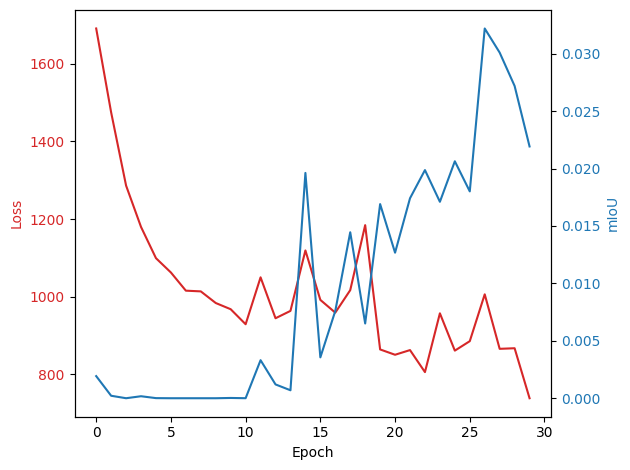

Training epoch 30


100%|██████████| 75/75 [00:33<00:00,  2.22batch/s, loss=552]    


- Log loss: 903.5265502929688
- mIoU: 0.015717914327979088
Training epoch 31


100%|██████████| 75/75 [00:32<00:00,  2.32batch/s, loss=606]    


- Log loss: 758.2548828125
- mIoU: 0.019583044573664665
Training epoch 32


100%|██████████| 75/75 [00:32<00:00,  2.29batch/s, loss=521]e+3]


- Log loss: 833.0264282226562
- mIoU: 0.023371806368231773
Training epoch 33


100%|██████████| 75/75 [00:32<00:00,  2.30batch/s, loss=739]    


- Log loss: 818.4631958007812
- mIoU: 0.023483963683247566
Training epoch 34


100%|██████████| 75/75 [00:32<00:00,  2.29batch/s, loss=522]    


- Log loss: 798.8099365234375
- mIoU: 0.026112377643585205
Training epoch 35


100%|██████████| 75/75 [00:32<00:00,  2.27batch/s, loss=919]    


- Log loss: 1265.1478271484375
- mIoU: 0.03382585570216179
Training epoch 36


100%|██████████| 75/75 [00:32<00:00,  2.30batch/s, loss=921]    


- Log loss: 739.2744750976562
- mIoU: 0.03081262856721878
Training epoch 37


100%|██████████| 75/75 [00:32<00:00,  2.28batch/s, loss=598]    


- Log loss: 657.3824462890625
- mIoU: 0.030144399031996727
Training epoch 38


100%|██████████| 75/75 [00:34<00:00,  2.19batch/s, loss=641]    


- Log loss: 740.0855102539062
- mIoU: 0.03220752626657486
Training epoch 39


100%|██████████| 75/75 [00:32<00:00,  2.30batch/s, loss=409]    


- Log loss: 869.809814453125
- mIoU: 0.02686312235891819


Training epoch 40


100%|██████████| 75/75 [00:32<00:00,  2.30batch/s, loss=920]    


- Log loss: 726.5962524414062
- mIoU: 0.029286589473485947
Training epoch 41


100%|██████████| 75/75 [00:32<00:00,  2.30batch/s, loss=393]    


- Log loss: 704.657958984375
- mIoU: 0.026983192190527916
Training epoch 42


100%|██████████| 75/75 [00:32<00:00,  2.31batch/s, loss=499]    


- Log loss: 708.48974609375
- mIoU: 0.03471636772155762
Training epoch 43


100%|██████████| 75/75 [00:32<00:00,  2.31batch/s, loss=313]    


- Log loss: 750.7985229492188
- mIoU: 0.033384859561920166
Training epoch 44


100%|██████████| 75/75 [00:32<00:00,  2.31batch/s, loss=737]    


- Log loss: 898.2463989257812
- mIoU: 0.02436494082212448
Training epoch 45


100%|██████████| 75/75 [00:33<00:00,  2.24batch/s, loss=694]    


- Log loss: 691.4579467773438
- mIoU: 0.030751211568713188
Training epoch 46


100%|██████████| 75/75 [00:32<00:00,  2.30batch/s, loss=324]    


- Log loss: 667.8392333984375
- mIoU: 0.03774264082312584
Training epoch 47


100%|██████████| 75/75 [00:33<00:00,  2.27batch/s, loss=454]    


- Log loss: 648.9334716796875
- mIoU: 0.03492611646652222
Training epoch 48


100%|██████████| 75/75 [00:32<00:00,  2.28batch/s, loss=594]    


- Log loss: 651.8527221679688
- mIoU: 0.031884726136922836
Training epoch 49


100%|██████████| 75/75 [00:32<00:00,  2.30batch/s, loss=471]    


- Log loss: 675.4677734375
- mIoU: 0.03952530026435852


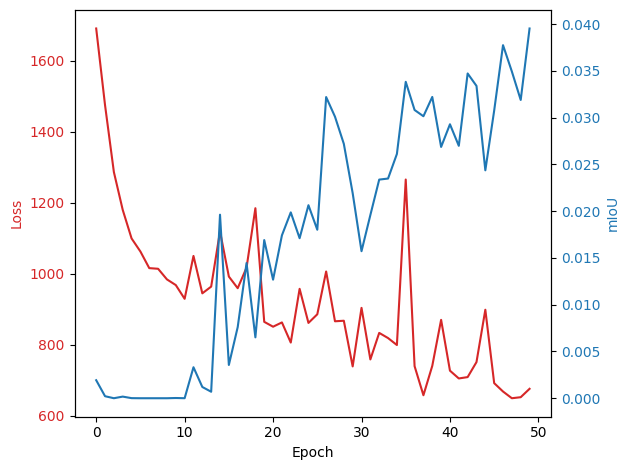

Training epoch 50


100%|██████████| 75/75 [00:32<00:00,  2.30batch/s, loss=507]    


- Log loss: 726.218505859375
- mIoU: 0.037334561347961426
Training epoch 51


100%|██████████| 75/75 [00:32<00:00,  2.30batch/s, loss=274]   


- Log loss: 660.6487426757812
- mIoU: 0.03422096371650696
Training epoch 52


100%|██████████| 75/75 [00:32<00:00,  2.32batch/s, loss=338]


- Log loss: 634.39404296875
- mIoU: 0.029494211077690125
Training epoch 53


100%|██████████| 75/75 [00:33<00:00,  2.23batch/s, loss=453]    


- Log loss: 616.0895385742188
- mIoU: 0.035962432622909546
Training epoch 54


100%|██████████| 75/75 [00:32<00:00,  2.29batch/s, loss=302]    


- Log loss: 567.7225341796875
- mIoU: 0.03466753661632538
Training epoch 55


 61%|██████▏   | 46/75 [00:20<00:12,  2.25batch/s, loss=449]    IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 75/75 [00:32<00:00,  2.32batch/s, loss=970]


- Log loss: 617.3505249023438
- mIoU: 0.03429979085922241
Training epoch 59


100%|██████████| 75/75 [00:32<00:00,  2.31batch/s, loss=675]


- Log loss: 610.7669677734375
- mIoU: 0.03703991696238518


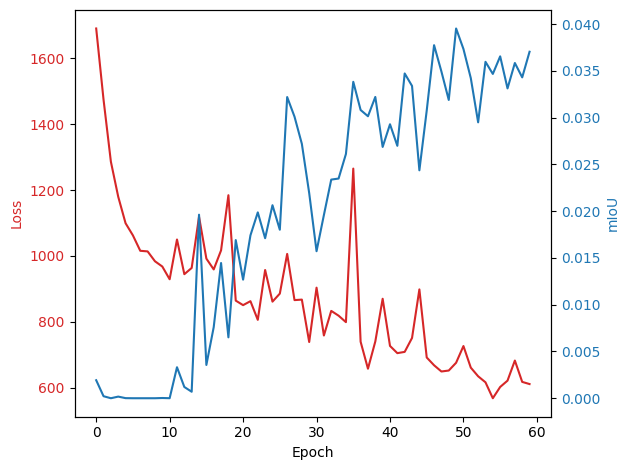

Training epoch 60


100%|██████████| 75/75 [00:32<00:00,  2.32batch/s, loss=354]    


- Log loss: 623.4883422851562
- mIoU: 0.04110630601644516
Training epoch 61


100%|██████████| 75/75 [00:33<00:00,  2.24batch/s, loss=692]   


- Log loss: 707.8519897460938
- mIoU: 0.03317801654338837
Training epoch 62


100%|██████████| 75/75 [00:32<00:00,  2.32batch/s, loss=287]    


- Log loss: 580.6203002929688
- mIoU: 0.030182041227817535
Training epoch 63


100%|██████████| 75/75 [00:32<00:00,  2.29batch/s, loss=373]    


- Log loss: 563.5205688476562
- mIoU: 0.036141011863946915
Training epoch 64


100%|██████████| 75/75 [00:32<00:00,  2.32batch/s, loss=749]


- Log loss: 571.4716796875
- mIoU: 0.03526074066758156
Training epoch 65


100%|██████████| 75/75 [00:32<00:00,  2.33batch/s, loss=158]


- Log loss: 579.9105224609375
- mIoU: 0.03754018247127533
Training epoch 66


100%|██████████| 75/75 [00:32<00:00,  2.30batch/s, loss=275]


- Log loss: 552.0573120117188
- mIoU: 0.035498425364494324
Training epoch 67


100%|██████████| 75/75 [00:32<00:00,  2.32batch/s, loss=424]


- Log loss: 538.1493530273438
- mIoU: 0.03655213862657547
Training epoch 68


100%|██████████| 75/75 [00:32<00:00,  2.31batch/s, loss=339]


- Log loss: 529.2684326171875
- mIoU: 0.03957509994506836
Training epoch 69


100%|██████████| 75/75 [00:33<00:00,  2.24batch/s, loss=634]


- Log loss: 581.9847412109375
- mIoU: 0.03663378581404686


Training epoch 70


100%|██████████| 75/75 [00:33<00:00,  2.27batch/s, loss=391]    


- Log loss: 587.0247802734375
- mIoU: 0.03591209650039673
Training epoch 71


100%|██████████| 75/75 [00:32<00:00,  2.30batch/s, loss=574]    


- Log loss: 552.5545654296875
- mIoU: 0.03906453400850296
Training epoch 72


100%|██████████| 75/75 [00:32<00:00,  2.30batch/s, loss=308]


- Log loss: 553.0833740234375
- mIoU: 0.03641151264309883
Training epoch 73


100%|██████████| 75/75 [00:32<00:00,  2.30batch/s, loss=296]    


- Log loss: 547.1998901367188
- mIoU: 0.03791557252407074
Training epoch 74


100%|██████████| 75/75 [00:32<00:00,  2.31batch/s, loss=486]


- Log loss: 553.9144287109375
- mIoU: 0.03275396302342415
Training epoch 75


100%|██████████| 75/75 [00:32<00:00,  2.29batch/s, loss=348]    


- Log loss: 532.1661987304688
- mIoU: 0.03968009352684021
Training epoch 76


100%|██████████| 75/75 [00:32<00:00,  2.31batch/s, loss=308]


- Log loss: 575.3317260742188
- mIoU: 0.03765571489930153
Training epoch 77


100%|██████████| 75/75 [00:34<00:00,  2.20batch/s, loss=400]


- Log loss: 538.4851684570312
- mIoU: 0.03985295072197914
Training epoch 78


100%|██████████| 75/75 [00:33<00:00,  2.27batch/s, loss=324]


- Log loss: 509.6293029785156
- mIoU: 0.038801755756139755
Training epoch 79


100%|██████████| 75/75 [00:32<00:00,  2.30batch/s, loss=333]


- Log loss: 544.575439453125
- mIoU: 0.039506636559963226


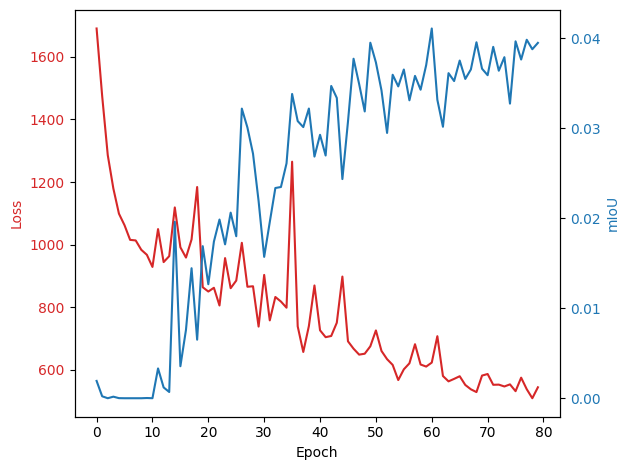

Training epoch 80


100%|██████████| 75/75 [00:32<00:00,  2.31batch/s, loss=241]


- Log loss: 534.0084228515625
- mIoU: 0.03903407230973244
Training epoch 81


100%|██████████| 75/75 [00:32<00:00,  2.32batch/s, loss=723]


- Log loss: 488.64593505859375
- mIoU: 0.04072687029838562
Training epoch 82


100%|██████████| 75/75 [00:32<00:00,  2.29batch/s, loss=375]    


- Log loss: 520.2838134765625
- mIoU: 0.03878116235136986
Training epoch 83


100%|██████████| 75/75 [00:32<00:00,  2.31batch/s, loss=216]   


- Log loss: 512.677490234375
- mIoU: 0.03785504028201103
Training epoch 84


100%|██████████| 75/75 [00:32<00:00,  2.29batch/s, loss=237]    


- Log loss: 508.9743347167969
- mIoU: 0.040760088711977005
Training epoch 85


100%|██████████| 75/75 [00:33<00:00,  2.23batch/s, loss=291]    


- Log loss: 511.9038391113281
- mIoU: 0.039066579192876816
Training epoch 86


100%|██████████| 75/75 [00:32<00:00,  2.31batch/s, loss=251]


- Log loss: 489.4157409667969
- mIoU: 0.04054732620716095
Training epoch 87


100%|██████████| 75/75 [00:33<00:00,  2.27batch/s, loss=292]


- Log loss: 491.471923828125
- mIoU: 0.03894899785518646
Training epoch 88


100%|██████████| 75/75 [00:32<00:00,  2.28batch/s, loss=317]


- Log loss: 480.14111328125
- mIoU: 0.04167960211634636
Training epoch 89


100%|██████████| 75/75 [00:33<00:00,  2.27batch/s, loss=226]    


- Log loss: 485.74688720703125
- mIoU: 0.03988315537571907


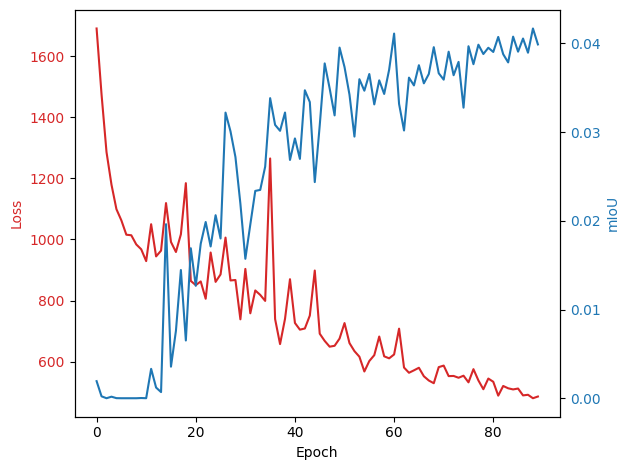

Training epoch 90


100%|██████████| 75/75 [00:32<00:00,  2.28batch/s, loss=492]


- Log loss: 500.0099182128906
- mIoU: 0.03768697381019592
Training epoch 91


100%|██████████| 75/75 [00:32<00:00,  2.29batch/s, loss=305]


- Log loss: 532.7548217773438
- mIoU: 0.03988350182771683
Training epoch 92


100%|██████████| 75/75 [00:32<00:00,  2.29batch/s, loss=155] 


- Log loss: 514.0797119140625
- mIoU: 0.040156710892915726
Training epoch 93


100%|██████████| 75/75 [00:32<00:00,  2.28batch/s, loss=250]


- Log loss: 500.66802978515625
- mIoU: 0.03983170539140701
Training epoch 94


100%|██████████| 75/75 [00:32<00:00,  2.30batch/s, loss=350]


- Log loss: 510.3733215332031
- mIoU: 0.03896789997816086
Training epoch 95


100%|██████████| 75/75 [00:32<00:00,  2.31batch/s, loss=280]


- Log loss: 493.10357666015625
- mIoU: 0.04155803099274635
Training epoch 96


100%|██████████| 75/75 [00:32<00:00,  2.33batch/s, loss=338]    


- Log loss: 498.7946472167969
- mIoU: 0.039574142545461655
Training epoch 97


100%|██████████| 75/75 [00:32<00:00,  2.34batch/s, loss=471]


- Log loss: 506.2122802734375
- mIoU: 0.04042653366923332
Training epoch 98


100%|██████████| 75/75 [00:32<00:00,  2.33batch/s, loss=432]


- Log loss: 495.7619934082031
- mIoU: 0.03987153246998787
Training epoch 99


100%|██████████| 75/75 [00:32<00:00,  2.34batch/s, loss=246]   


- Log loss: 487.0315246582031
- mIoU: 0.040258243680000305


Training epoch 100


100%|██████████| 75/75 [00:33<00:00,  2.27batch/s, loss=219]


- Log loss: 510.4925231933594
- mIoU: 0.04385392740368843
Training epoch 101


100%|██████████| 75/75 [00:32<00:00,  2.32batch/s, loss=200]


- Log loss: 497.0003356933594
- mIoU: 0.04047629237174988
Training epoch 102


100%|██████████| 75/75 [00:32<00:00,  2.33batch/s, loss=216]


- Log loss: 525.1389770507812
- mIoU: 0.04187855124473572
Training epoch 103


100%|██████████| 75/75 [00:32<00:00,  2.34batch/s, loss=329]


- Log loss: 502.5157470703125
- mIoU: 0.04274969920516014
Training epoch 104


100%|██████████| 75/75 [00:31<00:00,  2.35batch/s, loss=230]


- Log loss: 500.28759765625
- mIoU: 0.042896028608083725
Training epoch 105


100%|██████████| 75/75 [00:31<00:00,  2.35batch/s, loss=274]


- Log loss: 492.6571350097656
- mIoU: 0.04317975044250488
Training epoch 106


100%|██████████| 75/75 [00:32<00:00,  2.34batch/s, loss=298]


- Log loss: 492.5526123046875
- mIoU: 0.04045889154076576
Training epoch 107


100%|██████████| 75/75 [00:32<00:00,  2.34batch/s, loss=146]


- Log loss: 495.1252136230469
- mIoU: 0.038993947207927704
Training epoch 108


100%|██████████| 75/75 [00:33<00:00,  2.21batch/s, loss=222]    


- Log loss: 495.6020202636719
- mIoU: 0.04053455591201782
Training epoch 109


100%|██████████| 75/75 [00:32<00:00,  2.29batch/s, loss=379]


- Log loss: 497.8218078613281
- mIoU: 0.04163440689444542


Training complete!


In [13]:
# from models import *
# from trainer import *
# from loader import *
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.multivariate_normal import MultivariateNormal
import sys

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel

#python3 train.py 12 FINAL_12/

# Input arguments
# channels = int(sys.argv[1])
# out_dir = sys.argv[2]

channels = 12
out_dir = '/kaggle/working/train_out/'

# Set up 
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
model = model.to(device)
model = nn.DataParallel(model)

# Set up loss function
# loss_fn = MultiScalePoolingLoss(alpha=0.75, gamma=0.0, itr=4, ratio=[0.4, 0.2, 0.2, 0.3])
loss_fn = GuidedLoss()

train_dataset = MethaneLoader(device = "cuda", mode="train", plume_id=None, channels=channels)
test_dataset = MethaneLoader(device = "cuda", mode="test", plume_id=None, channels=channels)

#print(train_dataset.__len__())

train_loader = DataLoader(train_dataset, 
                          batch_size = 16, 
                          shuffle = True)

test_loader = DataLoader(test_dataset, 
                          batch_size = 16, 
                          shuffle = True)


# Make the trainer
trainer = Trainer(model,
                  train_loader,
                  test_loader,
                  train_dataset,
                  loss_fn,
                  out_dir,
                  1e-4)

# Train
trainer.train(n_epochs=110)

In [14]:
### for clearing directory
### skip it
#!rm -rf /kaggle/working/*

In [15]:
def visualize(idx):
    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)

    print(image1.shape, image2.shape, image3.shape)

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()

In [16]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

# from models import *
# from trainer import *
# from loader import *

from torch.utils.data import DataLoader
from glob import glob

# python3 gen_eval_preds.py 12 final_12_all/ final_12_preds/ 0
# in_dir = sys.argv[2]
# out_dir = sys.argv[3]
# channels = int(sys.argv[1])
# alli_yn = bool(int(sys.argv[4]))

in_dir = "/kaggle/working/train_out/"
out_dir = "/kaggle/working/eval_out/"
channels = 12
alli_yn = False

print("Loading losses...")
losses = np.load(in_dir+"losses.npy")
best_epoch = np.argmin(losses)
print('best epoch: ', best_epoch)

device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
# model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)
model = model.to(device)
model = nn.DataParallel(model)

model.load_state_dict(torch.load(in_dir+"final_model",
                      map_location=torch.device('cuda'))["model_state_dict"])
# model.load_state_dict(torch.load('/kaggle/input/ch4net_attention/pytorch/default/1/final_model',
#                       map_location=torch.device('cuda'))["model_state_dict"])
model.eval()
print()

Loading losses...
best epoch:  88


/tmp/ipykernel_36/1094549648.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(in_dir+"final_model",


In [17]:
import torch
import numpy as np

def calculate_iou(pred, target):
    """
    Calculate Intersection over Union (IoU)
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_accuracy(pred, target):
    """
    Calculate pixel-wise accuracy
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    correct = np.sum(pred == target)
    total = pred.size
    return correct / total

In [18]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import balanced_accuracy_score

def calculate_metrics(pred, target, epsilon=1e-6):
    """
    Calculate IoU, Accuracy, Recall, Balanced Accuracy, False Positive Rate, and False Negative Rate
    """
    pred = F.sigmoid(torch.tensor(pred)).numpy()
    pred = pred > 0.5 # Convert to binary mask
    target = target > 0  # Convert to binary mask
    
    true_positive = np.sum(np.logical_and(pred, target))
    false_positive = np.sum(np.logical_and(pred, np.logical_not(target)))
    false_negative = np.sum(np.logical_and(np.logical_not(pred), target))
    true_negative = np.sum(np.logical_and(np.logical_not(pred), np.logical_not(target)))
    
    # IoU
    union = np.sum(np.logical_or(pred, target))
    iou = (true_positive + epsilon) / (union + epsilon)
    
    # Accuracy
    total = pred.size
    accuracy = (true_positive + true_negative) / total
    
    # Recall (True Positive Rate)
    recall = (true_positive + epsilon) / (true_positive + false_negative + epsilon)
    
    # False Positive Rate
    fpr = (false_positive + epsilon) / (false_positive + true_negative + epsilon)
    
    # False Negative Rate
    fnr = (false_negative + epsilon) / (false_negative + true_positive + epsilon)
    
    # Balanced Accuracy
#     balanced_acc = balanced_accuracy_score(target.flatten(), pred.flatten())
    balanced_acc = None
    
    return iou, accuracy, recall, balanced_acc, fpr, fnr

# ... [Previous imports and setup code remains the same]

losses = []
ious = []
accuracies = []
recalls = []
balanced_accs = []
fprs = []
fnrs = []

loss_fn = GuidedLoss()

# Iterate over each plume
for i in tqdm(range(250)):
    preds = []
    targets = []

    test_dataset = MethaneLoader(
        device="cuda", mode="val", alli=alli_yn, plume_id=i, channels=channels)

    val_loader = DataLoader(test_dataset,
                            batch_size=64,
                            shuffle=False)

    for batch in val_loader:
        out = model(batch["pred"])
        preds.append(np.squeeze(out[0]).cpu())
        targets.append(np.squeeze(batch["target"]).cpu())
        loss_val = loss_fn(tuple(np.squeeze(o).unsqueeze(0) for o in out), np.squeeze(batch["target"]).unsqueeze(0))
        losses.append(loss_val.item())
        
    if len(preds) > 0:
        preds = torch.concat(preds, dim=0).detach().numpy()
        targets = torch.concat(targets, dim=0).detach().numpy()

        # Calculate metrics for this plume
        iou, accuracy, recall, balanced_acc, fpr, fnr = calculate_metrics(preds, targets)
        
        ious.append(iou)
        accuracies.append(accuracy)
        recalls.append(recall)
        balanced_accs.append(balanced_acc)
        fprs.append(fpr)
        fnrs.append(fnr)
        
        preds = F.sigmoid(torch.tensor(preds)).numpy()
        preds = preds > 0.5 # Convert to binary mask
        np.save(out_dir+f"out_{i}.npy", preds)
        np.save(out_dir+f"target_{i}.npy", targets)

# Calculate and print overall metrics
mean_loss = np.mean(losses)
mean_iou = np.mean(ious)
mean_accuracy = np.mean(accuracies)
mean_recall = np.mean(recalls)
# mean_balanced_acc = np.mean(balanced_accs)
mean_fpr = np.mean(fprs)
mean_fnr = np.mean(fnrs)

print(f"Mean Loss: {mean_loss:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
# print(f"Mean Balanced Accuracy: {mean_balanced_acc:.4f}")
print(f"Mean False Positive Rate: {mean_fpr:.4f}")
print(f"Mean False Negative Rate: {mean_fnr:.4f}")

# Save metrics
np.save(out_dir+"metrics.npy", {
    "loss": mean_loss,
    "iou": mean_iou,
    "accuracy": mean_accuracy,
    "recall": mean_recall,
#     "balanced_accuracy": mean_balanced_acc,
    "false_positive_rate": mean_fpr,
    "false_negative_rate": mean_fnr
})

100%|██████████| 250/250 [00:35<00:00,  7.07it/s]

Mean Loss: 55.3493
Mean IoU: 0.5348
Mean Accuracy: 0.9821
Mean Recall: 0.7239
Mean False Positive Rate: 0.0082
Mean False Negative Rate: 0.7902


pos
62.60000003740001


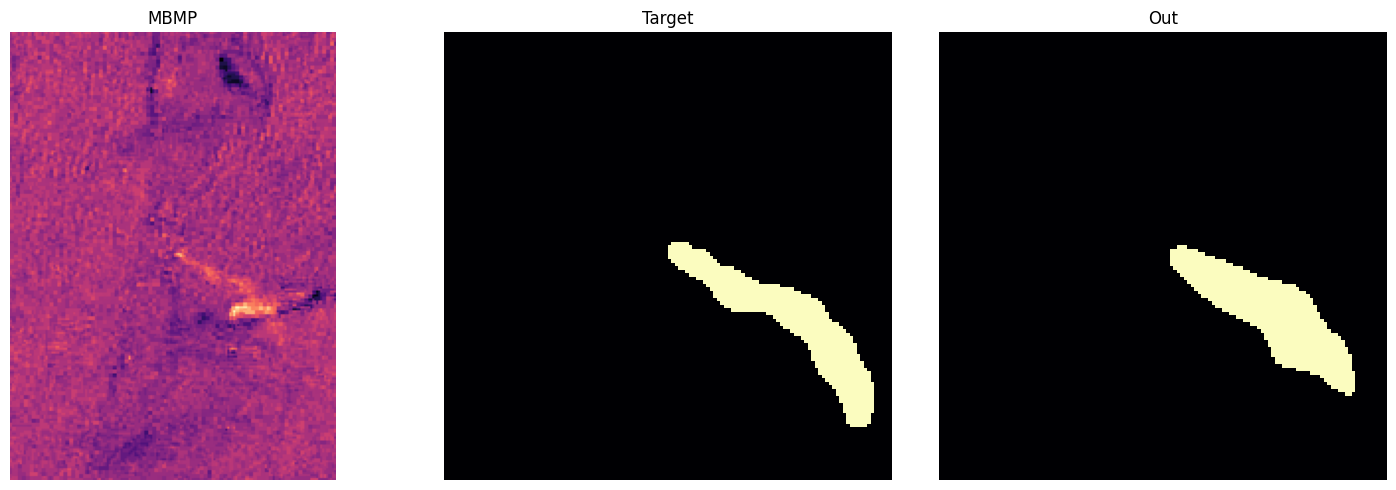

pos
37.46223574401475


neg
100.0


pos
61.103253237477716


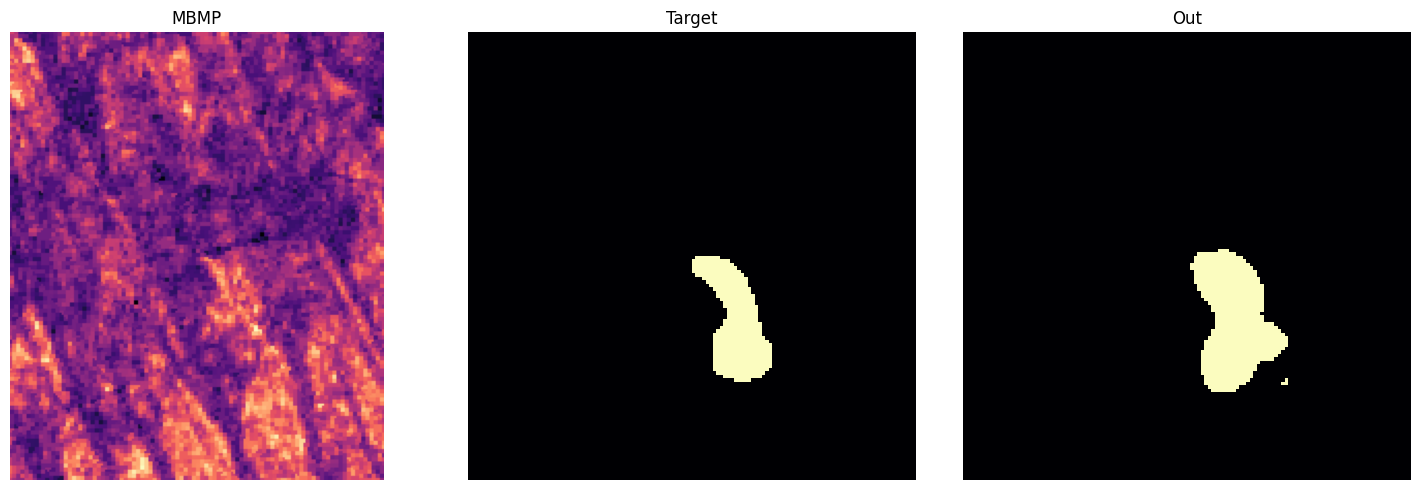

neg
100.0


pos
2.3474178348652165e-07


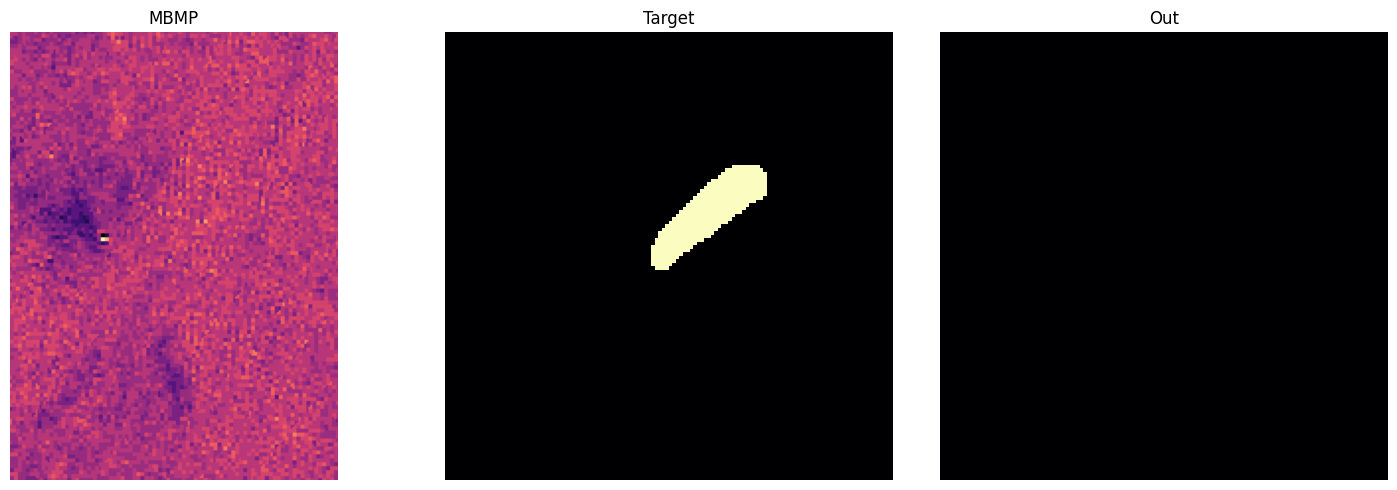

neg
4.2194092648970067e-07


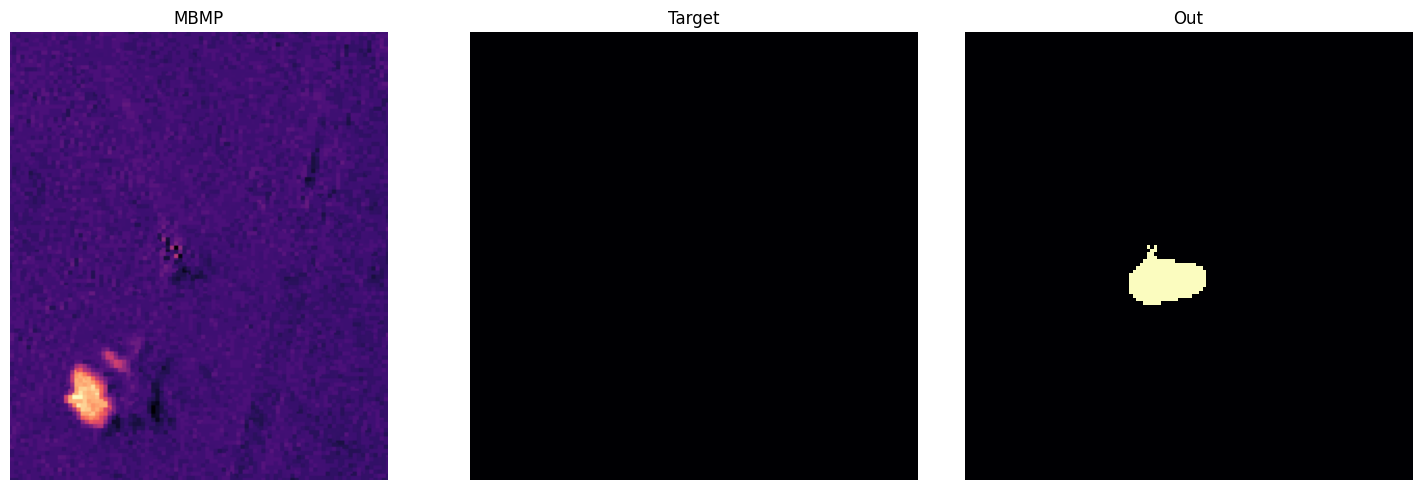

neg
100.0


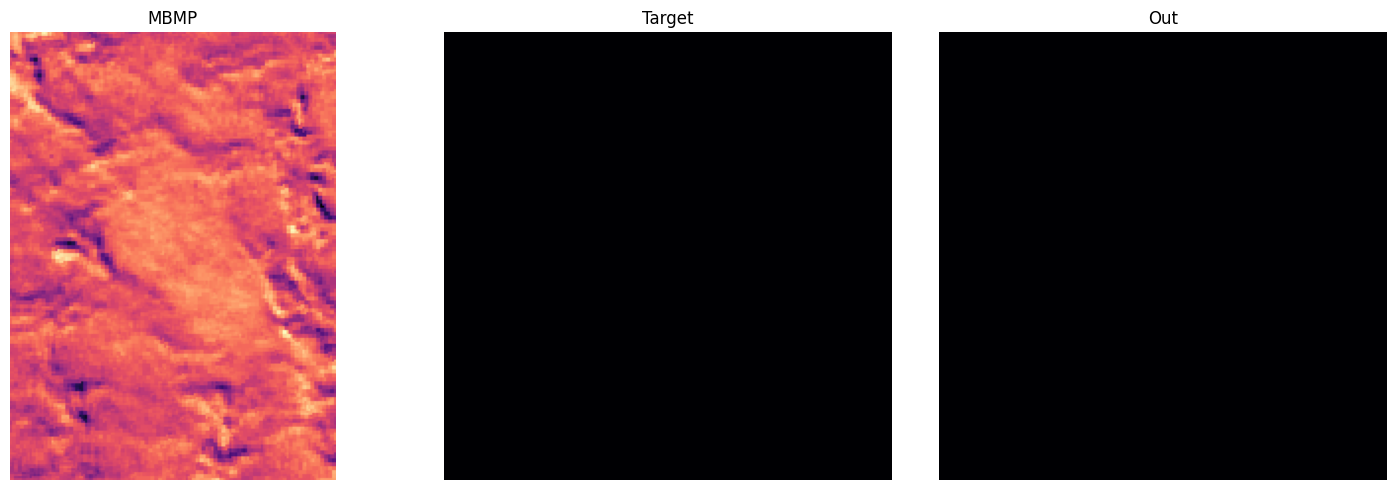

neg
100.0


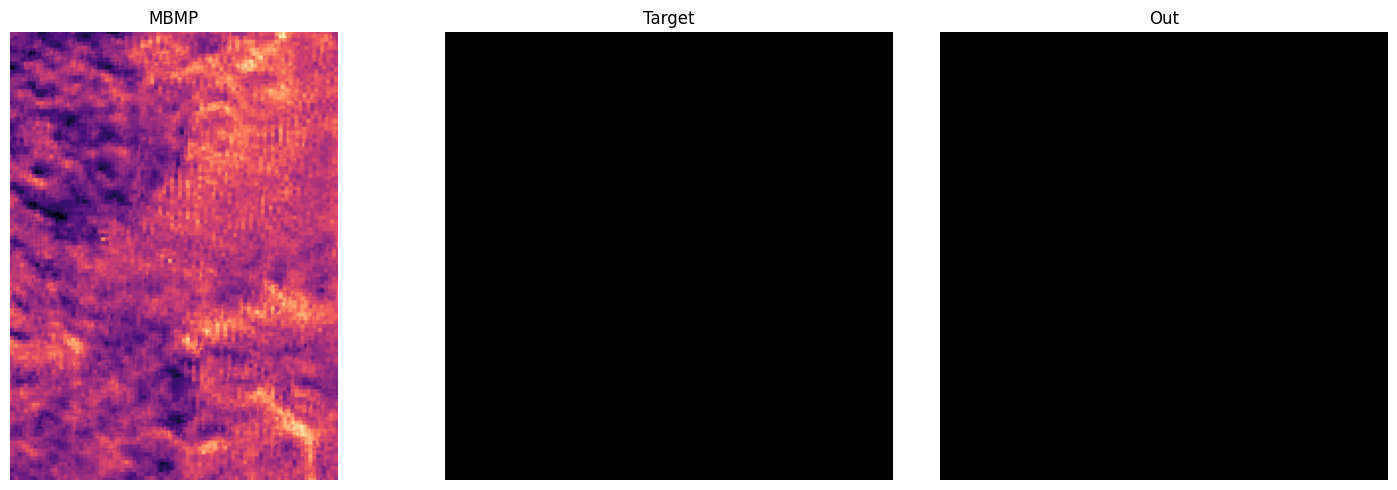

pos
54.946364773603854


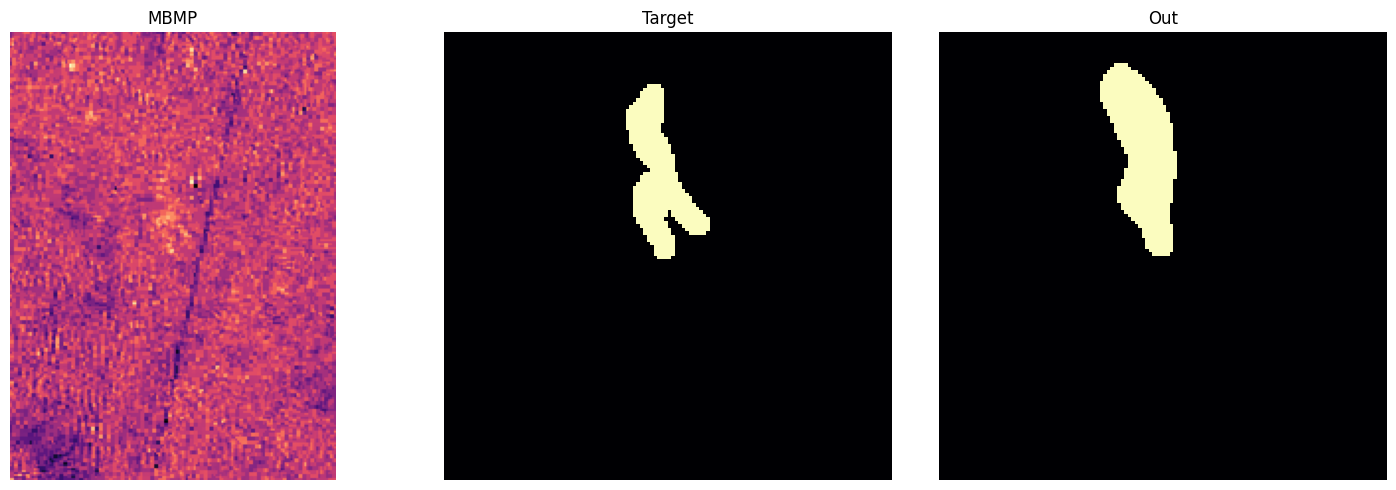

neg
100.0


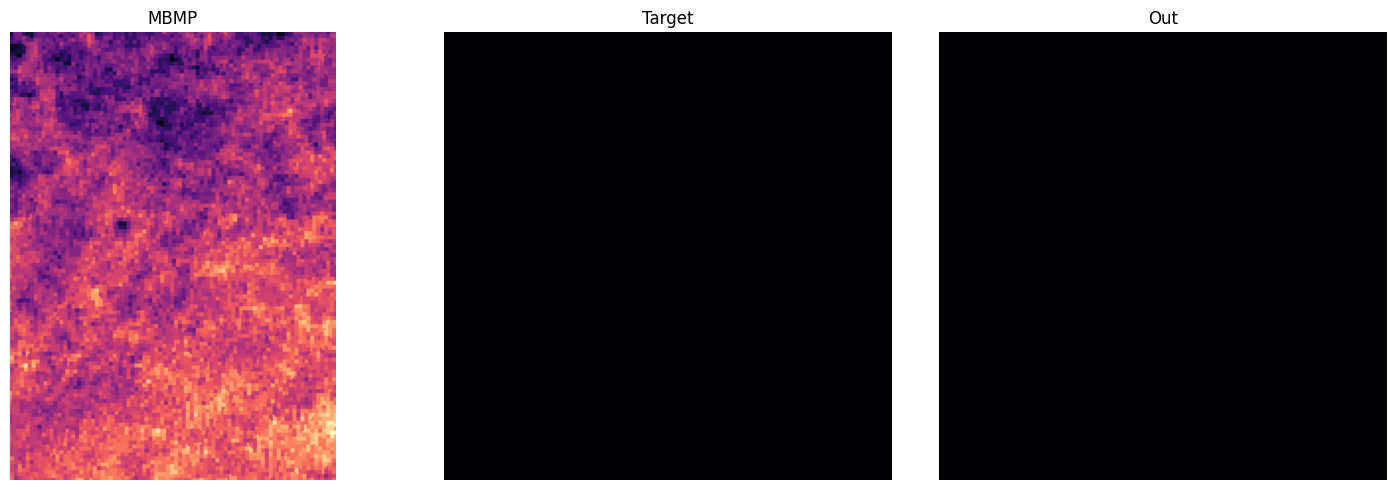

neg
100.0


neg
100.0


pos
13.972056059936017


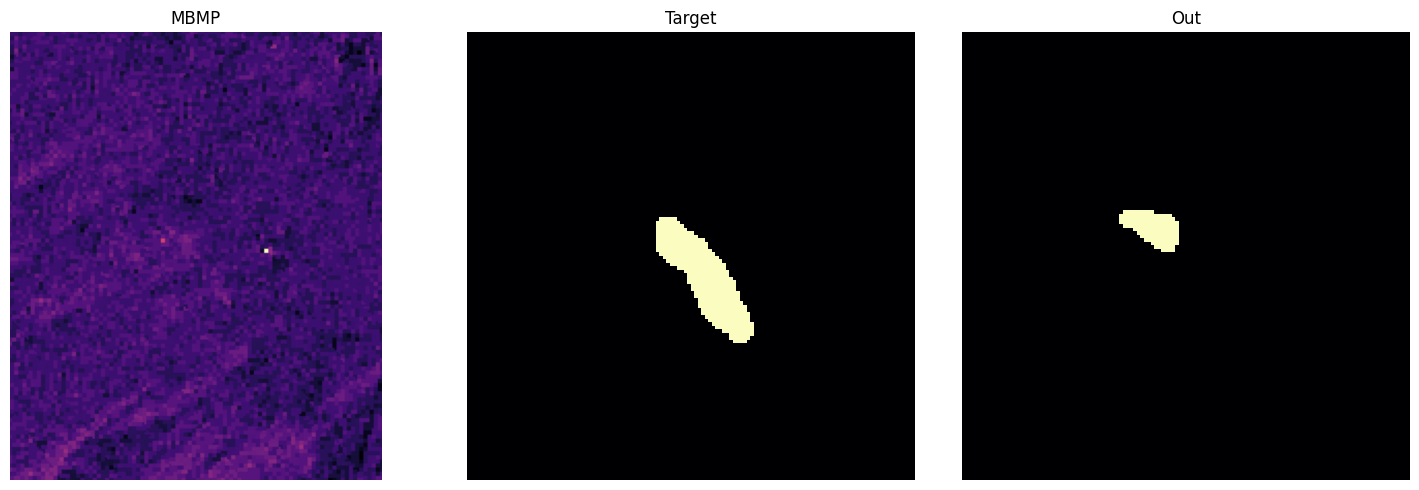

neg
100.0


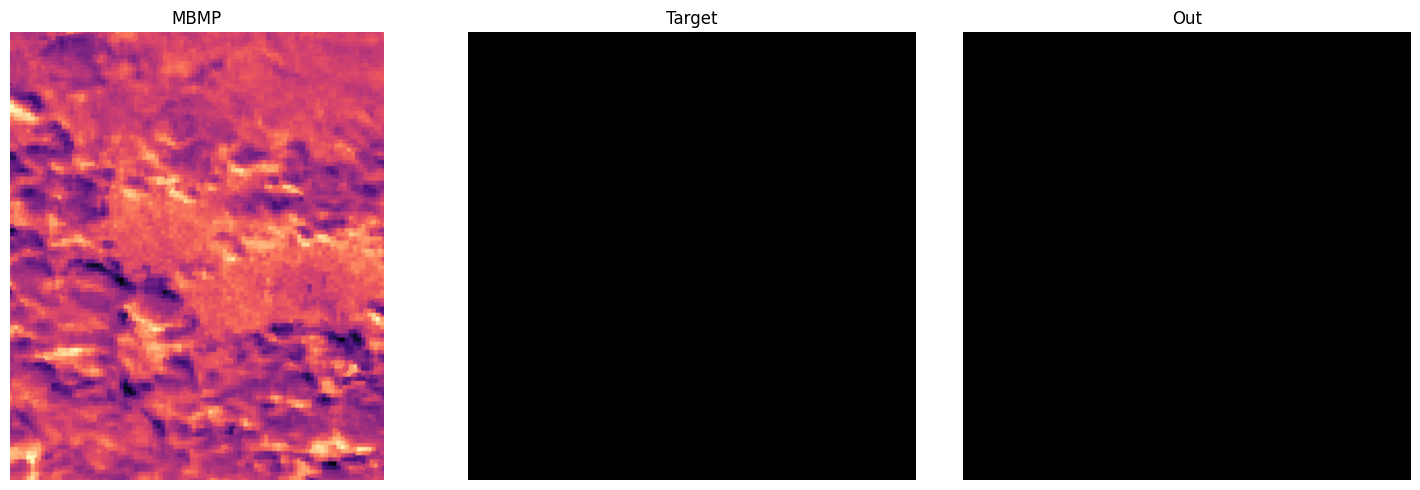

neg
100.0


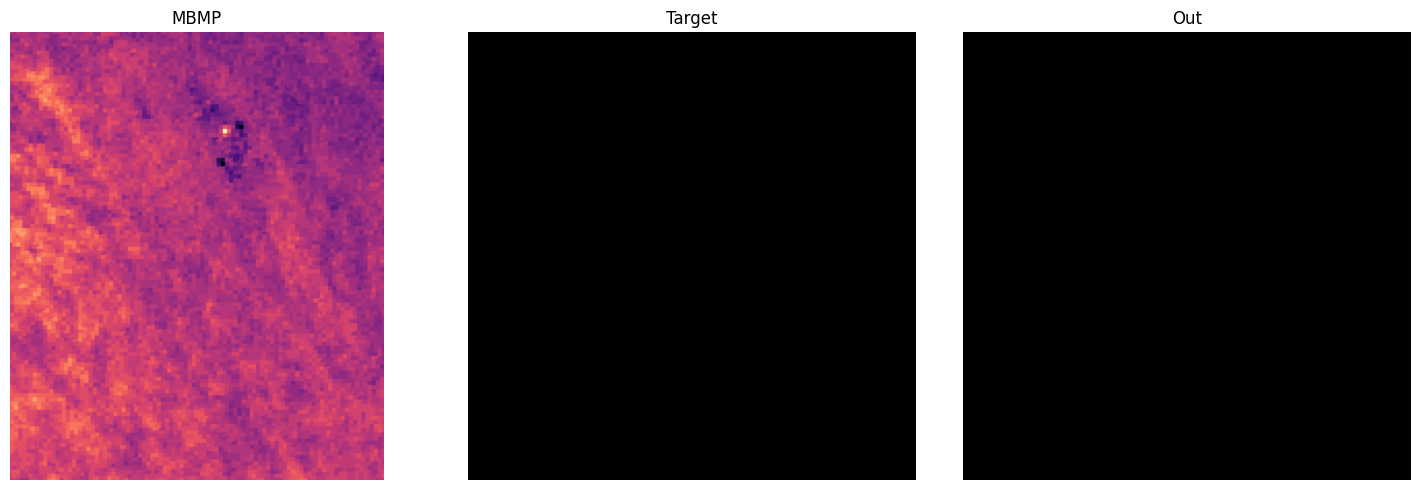

pos
48.558246887476066


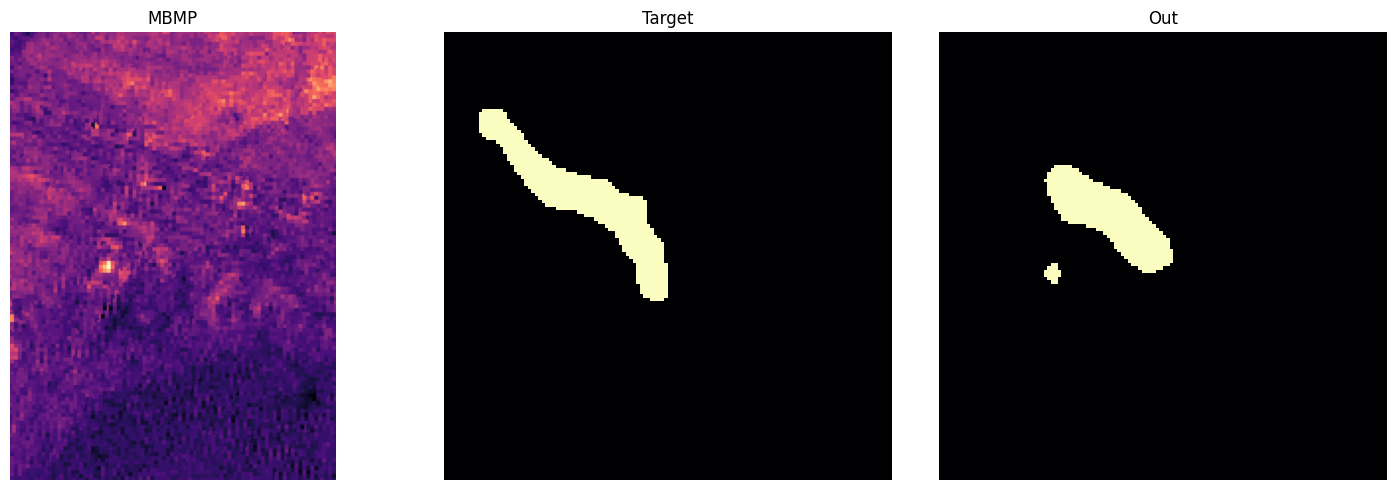

neg
9.174311842437506e-07


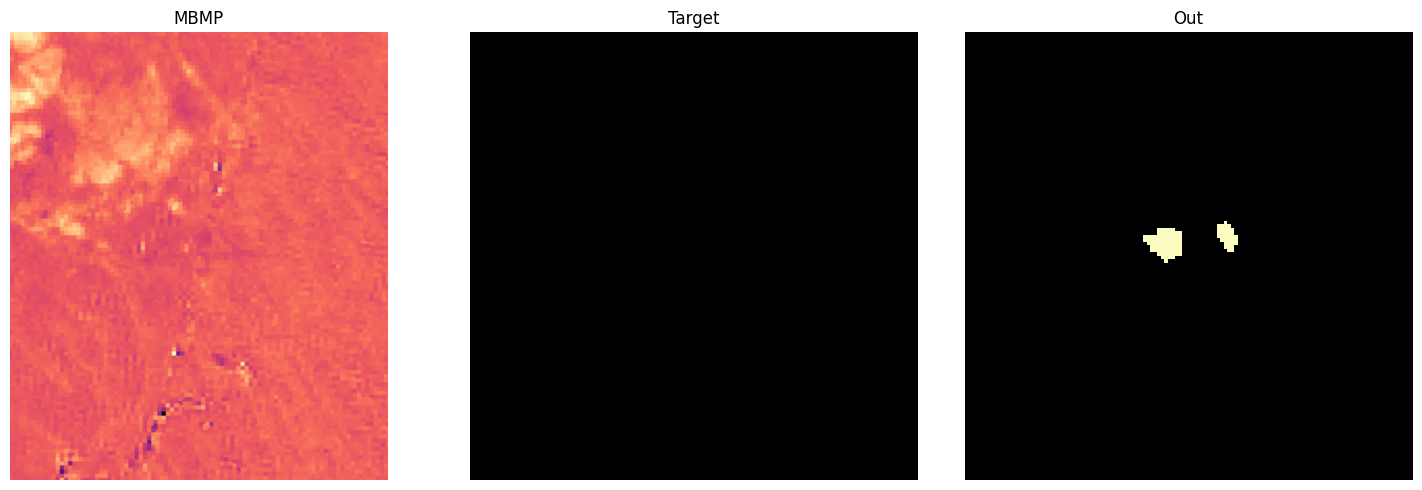

neg
100.0


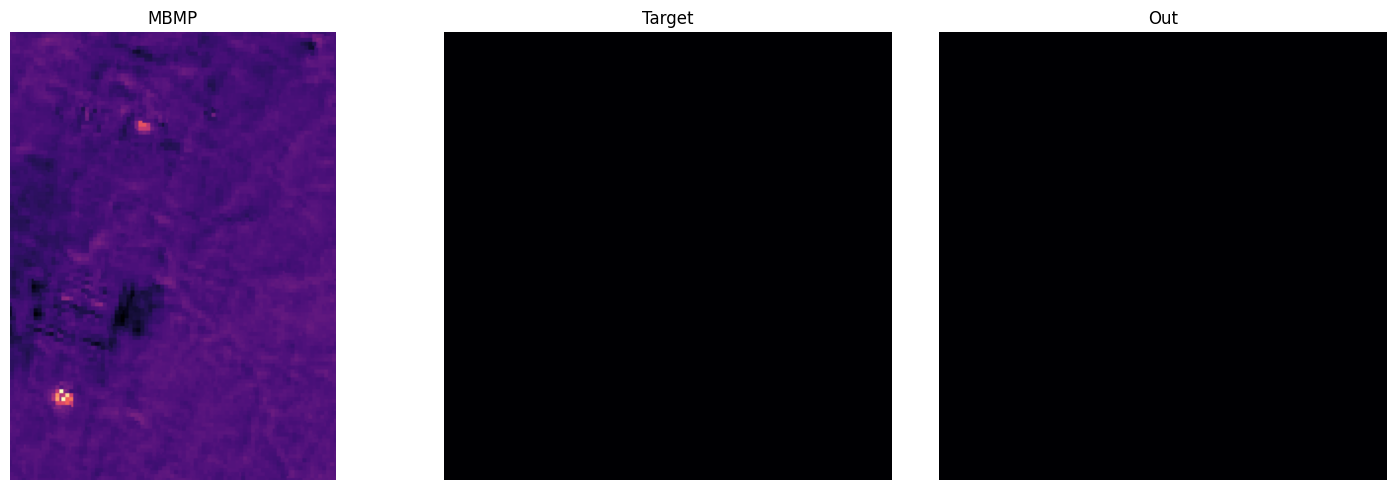

neg
100.0


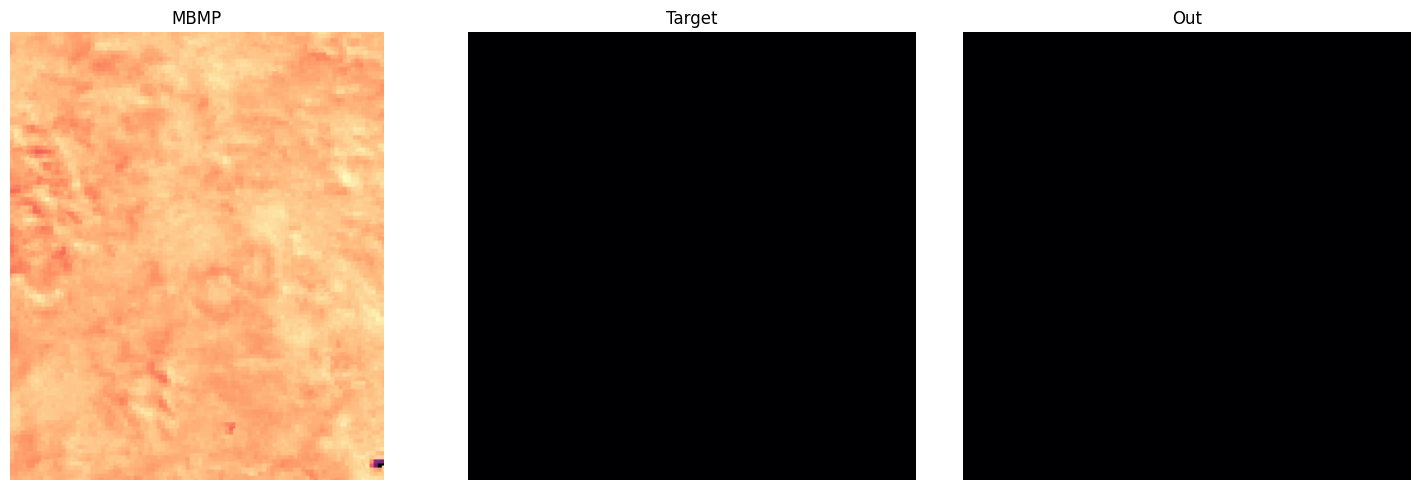

In [19]:
# from glob import glob

# visualize masks
samples = 250

# def visualize(idx):
    
for i in range(samples):
    idx = np.random.randint(0, samples)
#     idx = i

    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)
#     print(image2.shape)
    
    eps = 1e-6
    pred = image3
    target = image2
    iou = (np.sum(np.logical_and(pred, target)) + eps) / (np.sum(np.logical_or(pred, target)) + eps) * 100
    
    print(iou)

#     print(image1.shape, image2.shape, image3.shape)
#     print(losses[idx])

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()
    
    i = i + 1
    if(i==20): break
